In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds

import tf_robot_learning.kinematic as tk
import os, time

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()
if tf.__version__[0] == '2':
    tf.compat.v1.experimental.output_all_intermediates(True)

In [3]:
dt = 0.01
demos_xi = rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True)

In [4]:
center = np.array([0.4, 0., 0.4])
scale = .4
horizon_scale = 1

In [5]:
def make_augmented(demos_xi):
    demos_x = scale * np.repeat(demos_xi[:, :, :2], horizon_scale, axis=1) 
    
    demos_dx = np.gradient(scale * demos_xi[:, :, :2], axis=1) / (dt * horizon_scale)
    demos_ddx = np.gradient(demos_dx, axis=1) / (dt * horizon_scale)
    
    demos_dx = np.repeat(demos_dx, horizon_scale, axis=1)
    demos_ddx = np.repeat(demos_ddx, horizon_scale, axis=1)
    
    x_std, dx_std, ddx_std = [
        np.mean(np.std(demos_x, axis=0)),
        np.mean(np.std(demos_dx, axis=0)),
        np.mean(np.std(demos_ddx, axis=0))]

    demos_xi = np.concatenate([
        demos_x,
        np.random.normal(np.zeros_like(demos_x[:, :, :1]), x_std**2),
        demos_dx,
        np.random.normal(np.zeros_like(demos_x[:, :, :1]), dx_std**2),
        demos_ddx,
        np.random.normal(np.zeros_like(demos_x[:, :, :1]), ddx_std**2),
    ], axis=-1)

    demos_xi[:, :, :3] += center
    return demos_xi

demos_xi = make_augmented(rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True))

In [6]:
def get_batch(batch_size=10):
    idx = np.random.randint(0, demos_xi.shape[0]-1, batch_size)
    return demos_xi[idx], demos_xi[idx, 0, :]

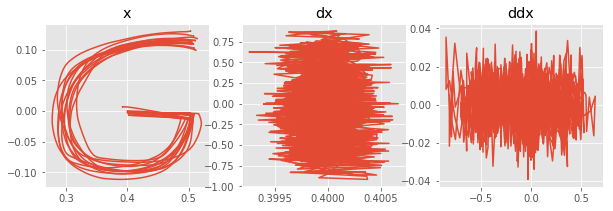

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
for i, title in enumerate(['x', 'dx', 'ddx']): ax[i].set_title(title)

for d in demos_xi:
    ax[0].plot(d[:, 0], d[:, 1])
    ax[1].plot(d[:, 2], d[:, 3])
    ax[2].plot(d[:, 4], d[:, 5])
    [_ax.set_prop_cycle(None) for _ax in ax]

In [8]:
xi_dim = 14  # size of state
u_dim = 7  # size of control command
batch_size_env = 1
batch_size_p = 5
batch_size = batch_size_env * batch_size_p  # batch_size (number of trajectories to evaluate in parrallel to compute gradient)
horizon = 200 # horizon of the rollouts to evaluate for computing gradients
demos_horizon = 200 # whole horizon of the demonstrations

In [9]:
def from_env_batch_to_batch(m):
    return tf1.batch_gather(m,
        [i for i in range(batch_size_env) for j in range(batch_size_p)])

In [10]:
xi0 = tf1.placeholder(tf.float32, (batch_size_env, xi_dim))
xi0_batch = from_env_batch_to_batch(xi0)

In [11]:
A, B = rl.control.utils.get_canonical(nb_deriv=2, nb_dim=u_dim, dt=dt)

In [12]:
sess.run(tf1.global_variables_initializer())

## Generator 

#### Push perturbation sequences 

In [13]:
def f(xi, u, t):
    xi_next = A.matvec(xi) + B.matvec(u)
    xi_next = xi_next
    return xi_next

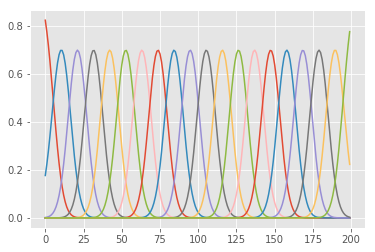

In [14]:
# basis functions to have smooth gains, targets and noise across the time
k_basis = 20
_, h = rl.utils.basis.build_fixed_psi(n_step=demos_horizon, n_dim=xi_dim, n_state=k_basis, scale=0.03)
plt.plot(h.eval());

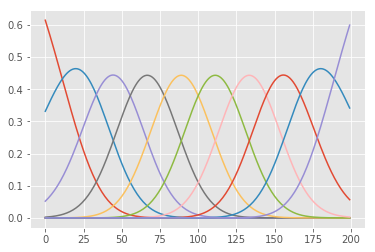

In [15]:
k_basis_cov = 10
_, h_cov = rl.utils.basis.build_fixed_psi(n_step=demos_horizon, n_dim=xi_dim, n_state=k_basis_cov, scale=0.1)
plt.plot(h_cov.eval());

In [16]:
urdf = tk.urdf_from_file(
	rl.datapath + '/urdf/panda_arm_gripper.urdf')

chain = tk.kdl_chain_from_urdf_model(
    urdf,
    tip='panda_leftfinger_tip'
)

In [29]:
n_experts = 2
experts_size = [7, 3]
experts_rest_pose = [tf.constant(chain.mean_pose, tf.float32), tf.constant(center, tf.float32)]
product_size = 7

In [30]:
pi_ks_p = [
    rl.p.make_cov(
        experts_size[i], 50. ** 0.5, param='diag', is_prec=False, batch_shape=(k_basis, )) 
    for i in range(n_experts)
]
pi_ks_v = [
    rl.p.make_cov(
        experts_size[i], 4. ** 0.5 , param='iso', is_prec=False, batch_shape=(k_basis, )) 
    for i in range(n_experts)
]
pi_covs = [
    rl.p.make_cov(experts_size[i], 15., param='iso', is_prec=False, batch_shape=(k_basis_cov, )) 
    for i in range(n_experts)
]

In [31]:
pi_target = [
    tf.Variable(experts_rest_pose[i] + tf.random.normal((k_basis, experts_size[i]), 0., .2))
    for i in range(n_experts)
]

In [32]:
pi_target_t = [
    tf.matmul(h, pi_target[i]) 
    for i in range(n_experts)]

pi_ks_p_t = [tf.einsum('ai,ijk->ajk', h, pi_ks_p[i]) for i in range(n_experts)]
pi_ks_v_t = [tf.einsum('ai,ijk->ajk', h, pi_ks_v[i]) for i in range(n_experts)]
pi_covs_t = [tf.einsum('ai,ijk->ajk', h_cov, pi_covs[i]) for i in range(n_experts)]

In [33]:
q = tf1.placeholder(tf.float32, (None, 7))
links = chain.xs(q)

def get_links(_q):
    return sess.run(links, {q: _q})

In [34]:
def damped_pinv_right(J, d=1e-5):
    """Minimizing x force"""
    return tf.matmul(tf.linalg.inv(tf.matmul(J, J, transpose_a=True) + d * tf.eye(J.shape[-1].value)), J,
                     transpose_b=True)


In [35]:
force = False

In [36]:
pis = [
    lambda y, dy, t : (tf.linalg.LinearOperatorFullMatrix(pi_ks_p_t[0][t]).matvec(pi_target_t[0][t] - y) -\
          tf.linalg.LinearOperatorFullMatrix(pi_ks_v_t[0][t]).matvec(dy),  pi_covs_t[0][t]),
    lambda y, dy, t: (tf.linalg.LinearOperatorFullMatrix(pi_ks_p_t[1][t]).matvec(pi_target_t[1][t] - y) -\
          tf.linalg.LinearOperatorFullMatrix(pi_ks_v_t[1][t]).matvec(dy),  pi_covs_t[1][t])
]

fs = [
    lambda x: x,
    lambda x: chain.xs(x)[:, -1, :3], # xy plane of last joint
]

if force:
    js = [
        lambda x: tf.linalg.LinearOperatorIdentity(u_dim, batch_shape=(batch_size, )),
        lambda x: tf.linalg.LinearOperatorFullMatrix(
                    tf.stop_gradient(chain.jacobian(x, layout=rl.kinematic.FkLayout.xq))[:, :3]),  
    ]
else:
    js = [
        lambda x: tf.linalg.LinearOperatorIdentity(u_dim, batch_shape=(batch_size, )),
        lambda x: tf.linalg.LinearOperatorFullMatrix(
            tf.stop_gradient(chain.jacobian(x, layout=rl.kinematic.FkLayout.xq)[:, :3])),  
    ]

In [37]:
if force:
    pi = rl.policy.ForcePoEPolicy(pis, u_dim, product_size, experts_size, fs, js)
else:
    pi = rl.policy.AccPoEPolicy(pis, u_dim, product_size, experts_size, fs, js)
pi.reg = 0.0

In [38]:
pi_params = []
for i in range(pi.n_experts):
    pi_params += [pi_ks_v[i].variable, pi_ks_p[i].variable, pi_target[i], pi_covs[i].variable]

In [39]:
ts0 = 0
samples_xis, samples_us= rl.control.rollout.make_rollout_samples(
    xi0_batch, f, pi.sample, u_dim=u_dim, T=demos_horizon-1, t0=ts0,
    batch_shape=batch_size)

In [40]:
samples_env_exp = [
    tf.reshape(fs[i](tf.reshape(samples_xis[:, :, :u_dim], (-1, u_dim))), 
           (batch_size_env, batch_size_p, -1, experts_size[i])) for i in range(n_experts)
]

In [41]:
# adding velocity
samples_env_exp += [
    tf.reshape(samples_xis[:, :, u_dim:], (batch_size_env, batch_size_p, -1, u_dim))
]

##  Discriminator

In [42]:
if tf.__version__[0] == '2':
    _shapes = [_s.shape[-1] for _s in samples_env_exp]
if tf.__version__[0] == '1':
    _shapes = [_s.shape[-1].value for _s in samples_env_exp]

In [43]:
# a batched Gaussian distribution of trajectory (each timestep independent)
p_data = [ds.MultivariateNormalFullCovarianceML(
    tf.Variable(tf.zeros((horizon, _size))),
    tf.Variable(tf.eye(_size, batch_shape=(horizon, ))),
) for _s, _size in zip(samples_env_exp, _shapes)]

p_samples = [ds.MultivariateNormalFullCovarianceML(
        tf.Variable(tf.zeros((batch_size_env, horizon, _size))),
        tf.Variable(tf.eye(_size, batch_shape=(batch_size_env, horizon, ))),
    data=tf.transpose(_s, (1, 0, 2, 3))
)  for _s, _size in zip(samples_env_exp, _shapes)]

In [44]:
# plotting utilities
p_data_plot = [rl.utils.plot.MVNPlot(_p_data) for _p_data in p_data]
p_samples_plot = [rl.utils.plot.MVNPlot(_p_samples) for _p_samples in p_samples]

In [45]:
# temperature of discriminator
temp = tf1.placeholder(tf.float32, ())

p_log_prob = tf.reduce_mean([rl.tf.log_normalize([
    temp * tf.reduce_mean(_p_data.log_prob(tf.transpose(_s, (1, 0, 2, 3))), axis=2), 
    temp * tf.reduce_mean(_p_samples.log_prob(tf.transpose(_s, (1, 0, 2, 3))), axis=2)
], axis=0)
for _s, _p_data, _p_samples in zip(samples_env_exp, p_data, p_samples)], axis=0)

In [46]:
p_data_prob = tf.exp(p_log_prob[0])

In [47]:
cost_gen = tf.reduce_mean(-p_log_prob[0])

In [48]:
cost_batch = tf.reduce_mean(-p_log_prob[0], axis=0)

In [49]:
rate_gen = tf1.placeholder(tf.float32, ())
optimizer_gen = tf1.train.AdamOptimizer(rate_gen)
    
train_gen = optimizer_gen.minimize(
    cost_gen, var_list=pi_params
)

Instructions for updating:
Use tf.cast instead.


In [50]:
init = tf1.global_variables_initializer()
### Create models 

### Loading data and learning samples model 

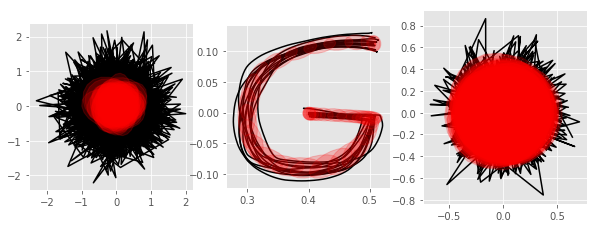

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
demos_xi = make_augmented(
    rl.utils.data.load_letter('G', get_x=True, get_dx=False, get_ddx=False, concat=True))

fake_data = [
    np.random.multivariate_normal(chain.mean_pose, 0.6 ** 2 * np.eye(u_dim), (20, horizon,)), # q
    demos_xi[:, :, :3],
    np.random.multivariate_normal(np.zeros(u_dim), 0.2 ** 2 * np.eye(u_dim), (20, horizon,)), # dq
]

reg = [[0.1] * 7, [0.01] * 3, [0.4] * 7 ]

for _p_data, _data, _reg in zip(p_data, fake_data, reg):
    _p_data.ml(_data, reg_diag=_reg)

dims = [0, 1]

for i, dim in enumerate([[0, 1], [0, 1], [0, 1]]):
    p_data_plot[i].plot_gmm(dim=dim, nb=5, ax=ax[i], alpha=0.2)
    for d in fake_data[i]:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], 'k')

## Training generator 

In [108]:
sess.run(init)

In [109]:
reg = [[2.] * 7, [0.01] * 3, [2.] * 7 ]


for _p_data, _data, _reg in zip(p_data, fake_data, reg):
    _p_data.ml(_data, reg_diag=_reg)

In [110]:
q0 =[-0.06947439,  0.31146526,  0.23839368, -1.4573636 ,  0.10949612,
        1.2345047 ,  0.00872206]

In [111]:
feed_dict = {
        rate_gen : 0.01,
        # rate_gen : 0.001,
        temp: 10.
    }
_batch_xi0 = np.concatenate(
            [np.random.multivariate_normal(q0, 0.02 ** 2 * np.eye(u_dim), (batch_size_env, )),
            np.random.multivariate_normal(np.zeros(u_dim), 0.02 ** 2 * np.eye(u_dim), (batch_size_env, )),], -1
        )
feed_dict[xi0] = _batch_xi0[:, :xi_dim]

In [114]:
n_it = 50000

feed_dict = {
        rate_gen : 0.03,
        # rate_gen : 0.001,
    }
for _p_samples, _reg in zip(p_samples, reg):
    feed_dict[_p_samples.reg_diag] = _reg

ml_op = [_p_samples.online_ml_op for _p_samples in p_samples]

for i in range(n_it):

        
    try:
        display.clear_output(wait=True)
        # generate samples from generator 
        _, _batch_xi0 = get_batch(batch_size_env)
        _batch_xi0 = np.concatenate(
            [np.random.multivariate_normal(q0, 0.02 ** 2 * np.eye(u_dim), (batch_size_env, )),
            np.random.multivariate_normal(np.zeros(u_dim), 0.02 ** 2 * np.eye(u_dim), (batch_size_env, )),], -1
        )
        feed_dict[xi0] = _batch_xi0[:, :xi_dim]
        # print i
        ################################
        # put 10 at the beginning and < 1 at the end
        feed_dict[temp] = 10.
        feed_dict[temp] = 100.
        # feed_dict[temp] = 1.
        # feed_dict[p_samples.alpha] = 1. if i == 0 else 0.01
        for _p_samples in p_samples:
            feed_dict[_p_samples.alpha] = .6
        ################################
        
        # _samples_phi_xis = sess.run([samples_phi_xis, p_samples.online_ml_op], feed_dict
        _ = sess.run(ml_op, feed_dict)
#         
        _ , _c_g, _c_b, _p_log_prob, _p_data = sess.run([
                train_gen, cost_gen, cost_batch, p_log_prob, p_data_prob], feed_dict)
        
        print('Cost \t\t: %.3f' % _c_g)
        print('Cost batch \t\t:' , _c_b)
        # print 'p_true\t\t: ', _p_data
        # print 'log_p_true\t: ', _p_log_prob[0]
    except KeyboardInterrupt:
        break

Cost 		: 44.482
('Cost batch \t\t:', array([44.481598], dtype=float32))


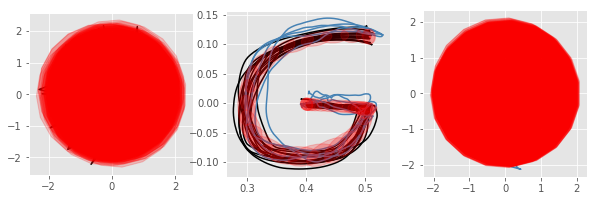

In [115]:
_samples_env_exp = sess.run(samples_env_exp, feed_dict=feed_dict)

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

dims = [0, 1]

for i, dim in enumerate([[0, 1], [0, 1], [0, 1]]):
    p_data_plot[i].plot_gmm(dim=dim, nb=5, ax=ax[i], alpha=0.2)
    for d in fake_data[i]:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], 'k')
        
    _s = _samples_env_exp[i]
    for j in range(batch_size_env):
        for l in range(batch_size_p):
            ax[i].plot(_s[j, l, :, dim[0]], _s[j, l, :, dim[1]], 'steelblue')

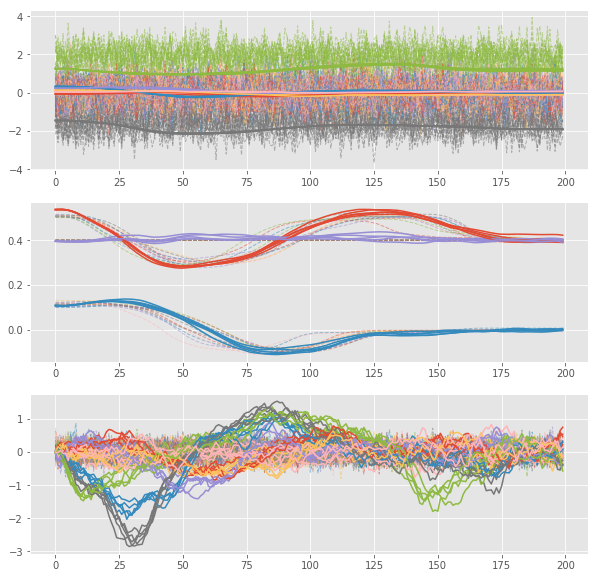

In [103]:
# _samples_env_exp[0][0][0][25]

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

dims = [0, 1]

for i, _s in enumerate(_samples_env_exp):
    ax[i].set_prop_cycle(None)
    for d in fake_data[i]:
        ax[i].plot(d, lw=1, alpha=0.5, ls='--')
        
    for j in range(batch_size_env):
        for l in range(batch_size_p):
            ax[i].set_prop_cycle(None)
            ax[i].plot(_s[j, l, :])

In [104]:
_samples_xis, _samples_env_exp = sess.run([samples_xis, samples_env_exp], feed_dict=feed_dict)

In [105]:
_linkss = np.array([get_links(_samples_xis[:, idx, :u_dim]) for idx in range(0, horizon)])
# for idx in range(0, 2):
for idx in range(0, horizon):
    _links = _linkss[idx]
    fig, ax = plt.subplots(nrows=2, figsize=(7, 8), sharex=True)
    ax[0].axis('off')
    ax[1].axis('off')
    
    for i in range(2):
        dim = [0, i + 1]
        chain.plot(
                _links, feed_dict={}, ax=ax[i],
                # rng=[0], dim=dim, alpha=1., color='k'
                dim=dim, alpha=1., color='k'
            )

        for j in range(batch_size):
            ax[i].plot(_linkss[:, j, -1, dim[0]], _linkss[:, j,  -1, dim[1]], 
                       color='orangered', alpha=0.3)

    ax[0].set_ylim([-0.3, .3])
    ax[1].set_ylim([-0.2, 1.2])
    for i in range(2):
        ax[i].set_xlim([-0.5, 1.2])
        ax[i].set_xlim([-0.5, 1.2])
    
    plt.savefig('fig_%d.png' % idx)
    plt.close()